# Task 1: Genes
### Alina, Lisa, Ömer and Nikolai

## Import Data

In [1]:
# Load libraries
import os
import warnings
import time

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, mutual_info_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from imblearn.over_sampling import SMOTE

# Remove two, Fuzzy doesn't seem to be very good and DBSCAN has no predict function
from fcmeans import FCM
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from tqdm import tqdm

In [2]:
# Configure libraries
warnings.filterwarnings("ignore")
RANDOM_STATE = 42

In [3]:
# Set location of data directory
data_path = os.path.join("..","Data-PR-As2","Genes")

In [4]:
# Load dataset (this takes a while)
df = pd.read_csv(os.path.join(data_path, "data.csv"))
df_labels = pd.read_csv(os.path.join(data_path, "labels.csv"))

In [5]:
# Remove first columns as they just contain row names
df = df.iloc[:, 1:]
df_labels = df_labels.iloc[:, 1:]

## Data Analysis

In [6]:
# Dimensions of data
n_observations, n_features = df.shape
print("# observations:",n_observations," # features:", n_features)
classes = df_labels["Class"].unique()
n_classes = len(classes)
print("There are", n_classes, "classes:", classes)

# observations: 801  # features: 20531
There are 5 classes: ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']


In [7]:
def plot_class_freq(y):
    ax = y.apply(pd.value_counts).plot(kind='bar', legend=False)
    if matplotlib.__version__[:3] == "3.5":
        ax.bar_label(ax.containers[0])
    else:
        print("Warning using old version of matplotlib!")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

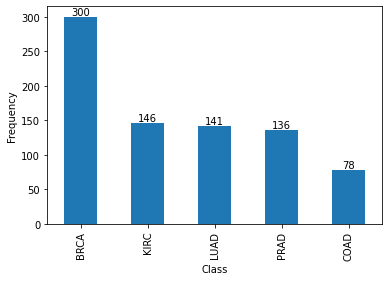

In [8]:
# Inspect frequency of class labels
plot_class_freq(df_labels)

There are 3 times more examples of BRCA than COAD. We therefore have a somewhat unbalanced dataset.

Min value: 0.0  Max value: 20.7788287118


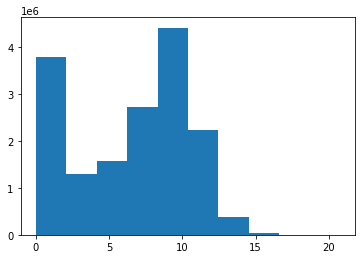

In [9]:
# Distribution of data across all features
df.stack().hist(grid=False)
df_np = df.to_numpy()
print("Min value:", df_np.min(), " Max value:", df_np.max())

In [10]:
# mean, std, min and max values vary between genes
df.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


In [11]:
print("Are there duplicate rows in the dataset?", any(df.duplicated()))

Are there duplicate rows in the dataset? False


In [12]:
def plot_tsne(x, y):
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
    X_tsne = tsne.fit_transform(x)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y.to_numpy().flatten(), 
                    palette=sns.color_palette(n_colors=n_classes), data=y)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

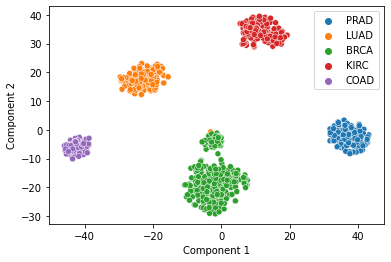

In [13]:
# Visualize multidimensional data
plot_tsne(df, df_labels)

In [14]:
# Remove samples to obtain a perfectly balanced set
def perfect_undersample(x, y):
    x_balanced = x.copy()
    y_balanced = y.copy()
    class_counts = y.apply(pd.value_counts)
    min_count = class_counts.min()['Class']
    for class_ in classes:
        class_count = class_counts.loc[class_]['Class']
        filtered = df_labels.loc[df_labels['Class'] == class_]
        remove_indices = filtered.sample(n=class_count - min_count, random_state=RANDOM_STATE).index
        y_balanced = y_balanced.drop(remove_indices)
        x_balanced = x_balanced.drop(remove_indices)
    return x_balanced, y_balanced

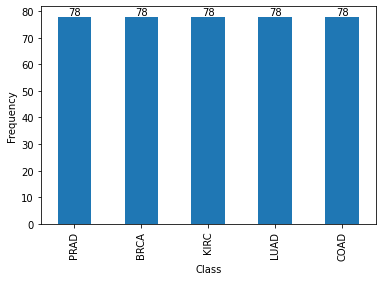

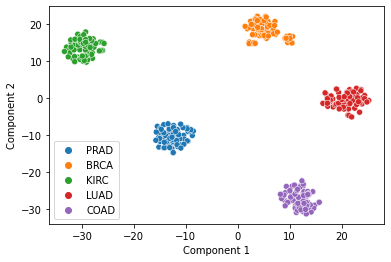

In [15]:
# Undersampled dataset
df_under, df_labels_under = perfect_undersample(df, df_labels)
plot_class_freq(df_labels_under)
plot_tsne(df_under, df_labels_under)

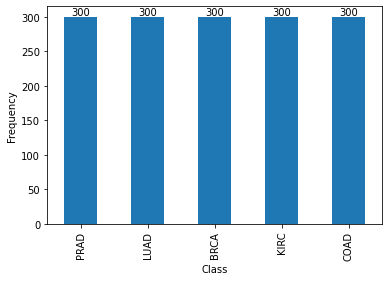

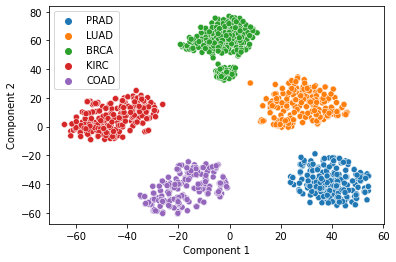

In [16]:
# Oversampled dataset
sm = SMOTE(sampling_strategy='not majority', k_neighbors=5, random_state=RANDOM_STATE)
df_over, df_labels_over = sm.fit_resample(df, df_labels)
plot_class_freq(df_labels_over)
plot_tsne(df_over, df_labels_over)

## Feature Selection / Dimension Reduction

### PCA

In [17]:
def plot_pca_comp_variance(x, comp=50):
    pca = PCA(n_components=comp)
    pca.fit(x)
    plt.plot(list(range(1, comp + 1)), pca.explained_variance_ratio_, "o-", linewidth=2)
    plt.title("Scree Plot")
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained")
    plt.show()

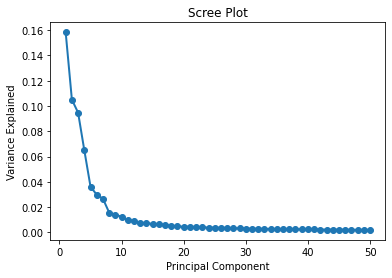

In [18]:
plot_pca_comp_variance(df)

In [19]:
def try_pca(components, x_train, y_train, x_test, y_test, model):
    scores = []
    for n in tqdm(components):
        pca = PCA(n_components=n)
        x_train_norm, x_test_norm = (x_train, x_test)
        X_train_pca = pca.fit_transform(x_train_norm)
        x_test_pca = pca.transform(x_test_norm)
        y_pred = model.fit(X_train_pca, y_train).predict(x_test_pca)
        scores.append(accuracy_score(y_test, y_pred))
    return scores

def find_best_pca(x, y, model, display=True, max_comp=10, split=0.2):
    components = list(range(1, max_comp + 1))
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=RANDOM_STATE)
    scores = try_pca(components, X_train, y_train, X_test, y_test, model)
    best_n_components = np.argmax(scores) + 1
    if display:
        model_name = model.__class__.__name__
        plt.plot(components, scores, 
                 label=f"{model_name}  (Min comp = {best_n_components}, Acc = {round(np.max(scores), 3)})")
        plt.xlabel("Number of Components")
        plt.ylabel("Model Accuracy")
    return best_n_components

100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.50s/it]


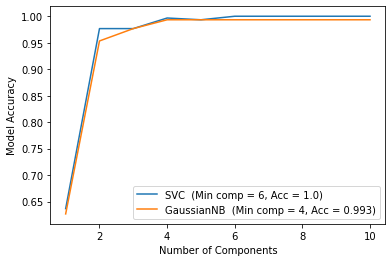

In [20]:
find_best_pca(df_over, df_labels_over, SVC())
find_best_pca(df_over, df_labels_over, GaussianNB())
plt.legend()
plt.show()

### Mutual Information

In [21]:
# This takes like a minute to run
def rank_features(x, y):
    selector = SelectKBest(mutual_info_classif, k="all")
    selector.fit(x, y)
    feature_importance = np.flip(np.argsort(selector.scores_))
    return feature_importance

In [22]:
def try_mutual_info(top_n_feat, top_features, x_train, y_train, x_test, y_test, model):
    scores = []
    for i in tqdm(range(1, top_n_feat + 1)):
        best_cols = top_features[:i]
        reduced_x_train = x_train.iloc[:,best_cols]
        reduced_x_test = x_test.iloc[:,best_cols]
        y_pred = model.fit(reduced_x_train, y_train).predict(reduced_x_test)
        scores.append(accuracy_score(y_test, y_pred))
    return scores

def find_best_mutual_info(features_ranked, x, y, model, display=True, top_n_feat=30, split=0.2):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=RANDOM_STATE)
    scores = try_mutual_info(top_n_feat, features_ranked, X_train, y_train, X_test, y_test, model)
    min_feat = np.argmax(scores) + 1
    if display:
        model_name = model.__class__.__name__
        plt.plot(list(range(1, top_n_feat + 1)), scores, label=f"{model_name}  (Min feat = {min_feat}, Acc = {round(np.max(scores), 3)})")
        plt.xlabel("Number of Top N Features used by Model")
        plt.ylabel("Model Accuracy")
        print(f"Top {min_feat} genes: {np.sort(features_ranked[:min_feat])}")
    return features_ranked[:min_feat]

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 142.32it/s]


Top 6 genes: [ 6593  7964  7965  7992 17109 18381]


100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 362.40it/s]


Top 26 genes: [ 2778  3540  3541  5407  5632  6593  6816  6830  6836  7421  7896  7964
  7965  7992  8003  8349 11393 11464 12568 15897 15900 16342 17109 18381
 18810 19159]


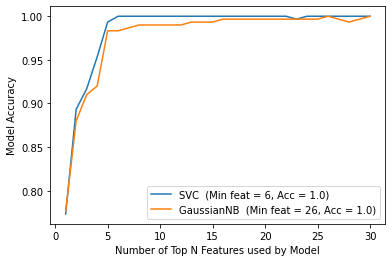

In [23]:
# This line takes a while
features_ranked = rank_features(df_over, df_labels_over)

find_best_mutual_info(features_ranked, df_over, df_labels_over, SVC())
find_best_mutual_info(features_ranked, df_over, df_labels_over, GaussianNB())
plt.legend()
plt.show()

## Classification (K-fold)

In [24]:
def get_train_test(type_: str, X_train, X_test, pca):
    if type_ == "PCA":
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    return X_train, X_test

def cross_val(model, df, df_labels, type_: str):
    pca = PCA(n_components=3)
    pred_times = []
    acc = []

    start_train = time.time()
    kf = StratifiedKFold(n_splits=5)
    for train_index, test_index in kf.split(df, df_labels):
        X_train, X_test = [df.iloc[i] for i in train_index], [df.iloc[i] for i in test_index]
        y_train, y_test = [df_labels.iloc[i] for i in train_index], [df_labels.iloc[i] for i in test_index]
        X_train, X_test = get_train_test(type_, X_train, X_test, pca)
        out = model.fit(X_train, y_train)
        start_pred = time.time()
        y_pred = out.predict(X_test)
        end_pred = time.time()
        pred_times.append(end_pred - start_pred)
        #acc.append(accuracy_score(y_test, y_pred))
        acc.append(mutual_info_score(np.array(y_test).flatten(), np.array(y_pred).flatten()))
    end_train = time.time()

    print(f"Model: {model}, with{'out' if type_ != 'PCA' else ''} PCA")
    print("avg training diff:", (end_train - start_train)/5)
    print("avg predicting diff:", sum(pred_times)/5)
    print("avg predicting acc:", sum(acc)/5)
    print("------------------------------------------")

In [25]:
X_cross = df_under
Y_cross = df_labels_under

# svm doesn't like a lot of data
# model = SVC()
# cross_val(model, X_cross, Y_cross, "n")
# cross_val(model, X_cross, Y_cross, "PCA")

model = GaussianNB()
cross_val(model, X_cross, Y_cross, "n")
cross_val(model, X_cross, Y_cross, "PCA")

model = KNeighborsClassifier(n_neighbors=3)
cross_val(model, X_cross, Y_cross, "n")
cross_val(model, X_cross, Y_cross, "PCA")


Model: GaussianNB(), without PCA
avg training diff: 0.11491012573242188
avg predicting diff: 0.0255584716796875
avg predicting acc: 1.1274872653919594
------------------------------------------
Model: GaussianNB(), with PCA
avg training diff: 0.3629270553588867
avg predicting diff: 0.0003565311431884766
avg predicting acc: 1.5323927643912483
------------------------------------------
Model: KNeighborsClassifier(n_neighbors=3), without PCA
avg training diff: 0.27710518836975095
avg predicting diff: 0.2050025463104248
avg predicting acc: 1.6089426125796458
------------------------------------------
Model: KNeighborsClassifier(n_neighbors=3), with PCA
avg training diff: 0.47120890617370603
avg predicting diff: 0.010550308227539062
avg predicting acc: 1.5320613364650952
------------------------------------------


## Clustering

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=RANDOM_STATE)
fcm = KMeans(n_clusters=5)
fcm.fit(X_train.to_numpy())

KMeans(n_clusters=5)

In [27]:
y_pred = fcm.predict(X_test.to_numpy())
mutual_info_score(y_pred, (y_test.to_numpy()).flatten())

1.5118205989941016